In [1]:
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

plt.ion()   # interactive mode

from Datasets import Generate_Dataloader

In [2]:
lr = 1e-2
momentum = 0.9
weight_decay = 1e-4

suffix = 'lr-2_sd44'
arch = 'vgg16_bn_ft'
workers = 4
dataset = 'CUB200'
sample_num = ''
batch_size = 32

gpu = 0
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

num_class = 200

print_freq = 50

In [3]:
if torch.cuda.is_available():
    print("Luckily you have at least a GPU!")
    device = torch.device("cuda:0")
else:
    print("Life is short, find a GPU...")
    device = torch.device("cpu")

Luckily you have at least a GPU!


In [4]:
# Load ft model
model_name = 'vgg16'
if model_name == 'vgg16':
    model = models.vgg16(pretrained=True)
    model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=num_class, bias=True)
    for name, module in model.named_modules():
        for param in module.parameters():
            param.requires_grad = False
    for param in model.classifier[6].parameters():
        param.requires_grad = True
    assert model.classifier[6].weight.requires_grad
    assert not model.classifier[3].weight.requires_grad
    
    feature_space = models.vgg16(pretrained=True)
    feature_space.classifier = nn.Sequential(*list(feature_space.classifier.children())[:-2])

In [5]:
# load training and validation data
train_loader, val_loader = Generate_Dataloader(dataset, batch_size, workers, suffix, sample_num)

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

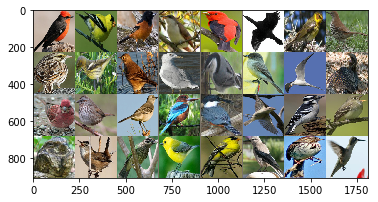

In [7]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [8]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
def train(train_loader, model, criterion, optimizer, epoch, dm = None):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    # top5 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (inputs, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        if dm!=None:
            dm.get(inputs)

        inputs = inputs.to(device)
        labels = labels.to(device)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # measure accuracy and record loss            
        losses.update(loss.item(), inputs.size(0))
        top1.update(torch.sum(preds == labels.data).double()/inputs.size(0), inputs.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
              'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
              'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
              'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
              'Acc@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
               epoch, i, len(train_loader), batch_time=batch_time,
               data_time=data_time, loss=losses, top1=top1))

In [10]:
def validate(val_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top0 = AverageMeter()
    top1 = AverageMeter()
    # top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (inputs, labels) in enumerate(val_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # compute output
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)

            # measure accuracy and record loss
            
            losses.update(loss.item(), inputs.size(0))
            top1.update(torch.sum(preds == labels.data).double()/inputs.size(0), inputs.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Acc@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1))
            
        print(' * Acc@1 {top1.avg:.3f}'.format(top1=top1))

    return top1.avg

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.5 every 5 epochs
# exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
for epoch in range(0,10):
    train(train_loader, model, criterion, optimizer, epoch)
    acc = validate(val_loader, model, criterion, epoch)
    # print("accuracy = {}".format(acc.item()))

Epoch: [0][0/188]	Time 0.819 (0.819)	Data 0.400 (0.400)	Loss 5.5932 (5.5932)	Acc@1 0.000 (0.000)
Epoch: [0][50/188]	Time 0.078 (0.092)	Data 0.000 (0.008)	Loss 3.6760 (4.4563)	Acc@1 0.281 (0.140)
Epoch: [0][100/188]	Time 0.077 (0.084)	Data 0.000 (0.004)	Loss 2.6081 (3.5817)	Acc@1 0.312 (0.238)
Epoch: [0][150/188]	Time 0.077 (0.082)	Data 0.000 (0.003)	Loss 2.6640 (3.1773)	Acc@1 0.375 (0.284)
Test: [0/182]	Time 0.487 (0.487)	Loss 1.5549 (1.5549)	Acc@1 0.562 (0.562)
Test: [50/182]	Time 0.076 (0.085)	Loss 1.8856 (1.6428)	Acc@1 0.500 (0.542)
Test: [100/182]	Time 0.077 (0.081)	Loss 1.4942 (1.6022)	Acc@1 0.531 (0.562)
Test: [150/182]	Time 0.078 (0.080)	Loss 1.4663 (1.7614)	Acc@1 0.656 (0.519)
 * Acc@1 0.523
Epoch: [1][0/188]	Time 0.462 (0.462)	Data 0.376 (0.376)	Loss 1.7672 (1.7672)	Acc@1 0.531 (0.531)
Epoch: [1][50/188]	Time 0.077 (0.086)	Data 0.000 (0.007)	Loss 1.1325 (1.4243)	Acc@1 0.688 (0.603)
Epoch: [1][100/188]	Time 0.079 (0.082)	Data 0.000 (0.004)	Loss 2.0195 (1.4368)	Acc@1 0.625 (0.59

In [14]:
feature_space = feature_space.to(device)

In [15]:
nth_target = 0

In [16]:
i = nth_target
for instances,labels in iter(val_loader):
    if len(instances) < i:
        i-=len(instances)
    else:
        target_instance = instances[i]
        target_label = labels[i]
        break

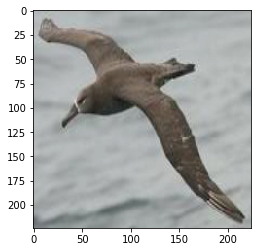

In [17]:
imshow(target_instance)

In [18]:
target_label.item()

0

In [19]:
flag = False
for instances,labels in iter(train_loader):
    for i in range(len(instances)):
        if labels[i].item() != target_label.item():
            base_instance = instances[0]
            base_label = labels[i]
            flag = True
            break
    if flag:
        break

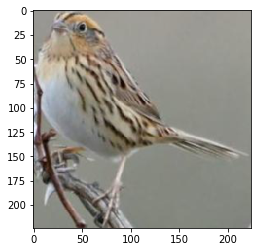

In [20]:
imshow(base_instance)

In [21]:
base_label.item()

123

In [22]:
feature_space = feature_space.to(device)
for name, module in feature_space.named_modules():
    for param in module.parameters():
        param.requires_grad = True

In [23]:
target_instance = target_instance.to(device)
base_instance = base_instance.to(device)
feature_space = feature_space.to(device)

In [81]:
def poison(feature_space, x, base_instance, target_instance, beta_0 = 0.25, lr=0.01):
    """
    base_instance b
    target_instance t
    """
    
    # x = x.to(device)
    x.requires_grad = True
    
    feature_space.eval()

    fs_t = feature_space(target_instance.view(1,*target_instance.shape)).detach()
    fs_t.requires_grad = False

    if model_name == 'vgg16':
        beta = beta_0 * model.classifier[6].in_features**2/(3*224*224)**2
    
    # Forward Step:
    dif = feature_space(x.view(1,*x.shape))-fs_t
    loss = torch.sum(torch.mul(dif,dif))
    loss.backward()

    x2 = x.clone()
    x2-=(x.grad*lr)

    # Backward Step:
    x = (x2+lr*beta*base_instance)/(1+lr*beta)
    
    return x, loss.item()
        

In [82]:
x = base_instance
for i in range(1000):
    x, loss = poison(feature_space, x.detach(), base_instance, target_instance)
    if i % 50 == 0:
        print(loss)

2642.326904296875
77.48955535888672
53.468055725097656
48.07415008544922
50.17938232421875
40.40865707397461
37.335426330566406
31.761089324951172
33.77301788330078
28.303050994873047
31.344467163085938
27.145729064941406
27.54717254638672
25.47278594970703
23.97551727294922
25.39969253540039
22.255107879638672
28.136014938354492
25.609615325927734
22.156023025512695


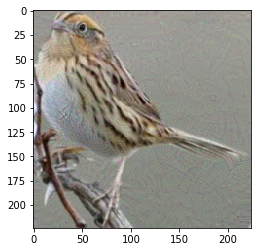

In [83]:
imshow(x.detach().cpu())

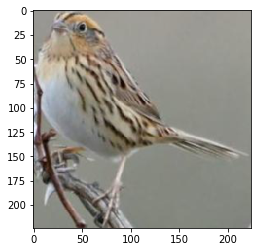

In [84]:
imshow(base_instance.detach().cpu())

In [55]:
class DataMask(object):
    def __init__(self,data,mask):
        self.data = data
        self.mask = mask
        self.size = 1
        for s in data.shape:
            self.size*=s

    def get(self, data):
        for i in range(len(data)):
            if torch.sum(data[i] == self.data).item()==self.size:
                data[i] = self.mask.detach()
                print("Masked")

In [56]:
dm = DataMask(base_instance.to('cpu'),x)

In [60]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.5 every 5 epochs
# exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [61]:
for epoch in range(0,10):
    train(train_loader, model, criterion, optimizer, epoch, dm)
    acc = validate(val_loader, model, criterion, epoch)
    # print("accuracy = {}".format(acc.item()))

Epoch: [0][0/188]	Time 0.616 (0.616)	Data 0.473 (0.473)	Loss 5.3659 (5.3659)	Acc@1 0.062 (0.062)
Masked
Epoch: [0][50/188]	Time 0.257 (0.185)	Data 0.000 (0.009)	Loss 3.2508 (4.4004)	Acc@1 0.281 (0.153)
Epoch: [0][100/188]	Time 0.141 (0.185)	Data 0.000 (0.005)	Loss 3.1577 (3.5598)	Acc@1 0.344 (0.238)
Epoch: [0][150/188]	Time 0.149 (0.183)	Data 0.000 (0.003)	Loss 2.6302 (3.1802)	Acc@1 0.406 (0.285)
Test: [0/182]	Time 0.730 (0.730)	Loss 1.6837 (1.6837)	Acc@1 0.531 (0.531)
Test: [50/182]	Time 0.281 (0.241)	Loss 1.7439 (1.5816)	Acc@1 0.594 (0.578)
Test: [100/182]	Time 0.282 (0.238)	Loss 1.6935 (1.6105)	Acc@1 0.531 (0.562)
Test: [150/182]	Time 0.280 (0.227)	Loss 1.5406 (1.7954)	Acc@1 0.594 (0.509)
 * Acc@1 0.503
Epoch: [1][0/188]	Time 0.798 (0.798)	Data 0.518 (0.518)	Loss 1.2710 (1.2710)	Acc@1 0.625 (0.625)
Masked
Epoch: [1][50/188]	Time 0.170 (0.204)	Data 0.000 (0.010)	Loss 1.3660 (1.4133)	Acc@1 0.594 (0.602)
Epoch: [1][100/188]	Time 0.149 (0.199)	Data 0.000 (0.005)	Loss 1.9888 (1.3905)	Acc

In [66]:
def predict(inp):
    _, preds = torch.max(model(inp.view(1,*inp.shape)),1)
    return preds[0].item()

In [67]:
predict(x)

123

In [68]:
predict(base_instance)

123

In [69]:
predict(target_instance)

123

In [13]:
def input_dif(x, y):
    x = x.to(device)
    y = y.to(device)
    loss = torch.sum(torch.mul(x-y,x-y))
    return loss.item()

In [14]:
def fs_dif(feature_space, x, y):
    feature_space = feature_space.to(device)
    feature_space.eval()
    x = x.to(device)
    y = y.to(device)
    fs_x = feature_space(x.view(1,*x.shape)).detach()
    fs_y = feature_space(y.view(1,*y.shape)).detach()
    loss = torch.sum(torch.mul(fs_x-fs_y,fs_x-fs_y))
    return loss.item()

In [15]:
fs_dif(feature_space,x,target_instance)

NameError: name 'x' is not defined

In [128]:
fs_dif(feature_space,x,base_instance)

2602.926513671875

In [129]:
input_dif(x,target_instance)

111744.765625

In [130]:
input_dif(x,base_instance)

788.7154541015625

In [17]:
class0 = []
class1 = []
for instances,labels in iter(val_loader):
    for i in range(len(instances)):
        if labels[i].item() == 0:
            class0.append(instances[i])
        elif labels[i].item() == 1:
            class1.append(instances[i])

In [123]:
len(class0)

30

In [124]:
len(class1)

30

In [137]:
inter_class_fs_dif = []
for i in range(len(class0)):
    inter_class_fs_dif.append(fs_dif(feature_space,class0[i],class1[i]))

In [138]:
intra_class0_fs_dif = []
for i in range(len(class0)):
    intra_class0_fs_dif.append(fs_dif(feature_space,class0[0 if i+1==len(class0) else i+1],class0[i]))

In [143]:
intra_class1_fs_dif = []
for i in range(len(class0)):
    intra_class1_fs_dif.append(fs_dif(feature_space,class1[0 if i+1==len(class0) else i+1],class1[i]))

In [141]:
np.mean(inter_class_fs_dif)

2214.747273763021

In [142]:
np.mean(intra_class0_fs_dif)

1736.6274983723958

In [144]:
np.mean(intra_class1_fs_dif)

2260.3359415690106

In [149]:
inter_class_input_dif = []
for i in range(len(class0)):
    inter_class_input_dif.append(input_dif(class0[i],class1[i]))

In [146]:
intra_class0_input_dif = []
for i in range(len(class0)):
    intra_class0_input_dif.append(input_dif(class0[0 if i+1==len(class0) else i+1],class0[i]))

In [147]:
intra_class1_input_dif = []
for i in range(len(class0)):
    intra_class1_input_dif.append(input_dif(class1[0 if i+1==len(class0) else i+1],class1[i]))

In [150]:
np.mean(inter_class_input_dif)

363461.6776041667

In [151]:
np.mean(intra_class0_input_dif)

331681.8796875

In [152]:
np.mean(intra_class1_input_dif)

351650.6393229167

In [18]:
inp = class0[0]

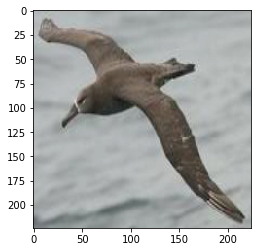

In [19]:
imshow(inp.detach().cpu())

In [20]:
np_inp = inp.cpu().numpy()

In [67]:
perturb = torch.tensor(np_inp + np.random.randn(*np_inp.shape)/85)

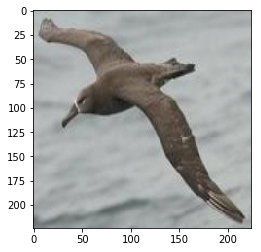

In [68]:
imshow(perturb)

In [69]:
input_dif(inp.float(),perturb.float())

20.816293716430664

In [70]:
fs_dif(feature_space,inp.float(),perturb.float())

19.113994598388672